In [14]:
## First import general packages for running python analysis:
import os, h5py, datetime,pytz
import numpy as np
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pickle, glob, yaml

from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals import beammap as bp
import beamcals.beam_autoprocessing as ba
from beamcals.sites import site

gbosite=site.site('../beamcals/beamcals/sites/GBO_config.npz')


freqs = 800.0*np.ones(1024) + (-400/1024.)*np.arange(1024)

fitdir='/hirax/GBO_Analysis_Outputs/main_beam_fits/'
ymldir = '/hirax/GBO_Analysis_Outputs/concat_config_files/'
pckldir = '/hirax/GBO_Analysis_Outputs/flight_pickles/bgonly/'
ampdir = '/hirax/GBO_Analysis_Outputs/amplitude_corrections/'
beamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles/'
polbeamdir = '/hirax/GBO_Analysis_Outputs/beam_pickles_polar/'

In [15]:
def get_flightinfo(fly):
    with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
        documents = yaml.safe_load(fff)
    flights = documents["flight_info"]["flights"]
    
    for fi in range(0,len(documents["flight_info"]["flights"])):
        if fly == flights[fi]: f = fi
    
    if polarn[f]=='N':
        pols = N_pols
        cpols = E_pols
    else:
        pols = E_pols
        cpols = N_pols
    return polarn[f], pols, cpols, attns[f], f

def get_slice(beam,Z,val, sliceOrientation='h'):
    # this gradually increases the tolerance until it finds something
    tol = abs(beam.x_centers_grid[1,0,0] - beam.x_centers_grid[0,0,0])/1.5
    N = len(beam.x_centers_grid[:,0,0]) #figure out the importance of this 
    ok = True
    while(ok):
        if sliceOrientation=='h': #keeping the y value constant and changing the x value 
            sliceIndex = np.where((beam.y_centers_grid[0,:,0] < (val + tol)) & (beam.y_centers_grid[0,:,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
                #still need to do this one 
        if sliceOrientation=='v':#keeping the x value constant and changing the y value 
            sliceIndex = np.where((beam.x_centers_grid[:,0,0] < (val+tol)) & (beam.x_centers_grid[:,0,0] > (val-tol)))[0]
            n = np.count_nonzero(np.isfinite(Z)) #count number of 'good' data
            if n > 10: ok = False
            else: ok = True
        tol+=1
        if tol > 30: ok = False
    return sliceIndex[0]


def get_slice_xy(xes,yes,val,ax='x'):
    tol = 2
    if ax=='x':
        col = np.where((xes < val+tol) & (xes > val-tol))[0]
    if ax=='y':
        col = np.where((yes < val+tol) & (yes > val-tol))[0]
    return col


def get_stat(new_d,whstat='stddev'): # default is stddev
    diff_flat = np.ndarray.flatten(new_d)
    if whstat=='stddev':
        stat = np.nanstd(diff_flat)
    elif whstat=='median':
        # compute median
        stat = np.abs(np.nanmedian(diff_flat))
    elif whstat=='sum':
        stat = np.nanmean(np.abs(diff_flat))
    return stat



In [16]:
with open('/hirax/GBO_Analysis_Outputs/GBO_flights_forscripts.yaml', 'r') as fff:
    documents = yaml.safe_load(fff)
flights = documents["flight_info"]["flights"]
N_pols = documents["flag_info"]["N_pols"]
E_pols = documents["flag_info"]["E_pols"]
polarn = documents["flight_info"]["pols"]
attns = documents["flight_info"]["attns"]
masks = documents["flight_info"]["masks"]
good_freqs = documents["freq_info"]["good_freqs"]

pcklarr=np.sort(os.listdir(pckldir))
gfitarr=np.sort(os.listdir(fitdir))
amparr=np.sort(os.listdir(ampdir))
print(gfitarr,amparr)


# SLICE DEFAULTS # 
sliw = 10 # This defines slices for (some) plots
sz = 80 # use this to set the size of the Xargs and Yargs for beammapping, usually 80 or 50

# PLOTTING DEFAULT # 
cmap = matplotlib.cm.get_cmap('gnuplot2')
norm = matplotlib.colors.Normalize(vmin=-25, vmax=25)
sfig = False

Npolflights = ['618','619','625','646','647','533','536']
Epolflights = ['620','648','649','535']

find = 900

cmm = cm.magma
fsz=16

['FLY533_20210826T182904Z_2dGauss_and_Airy_Params.npz'
 'FLY534_20210826T185621Z_2dGauss_and_Airy_Params.npz'
 'FLY535_20210826T192056Z_2dGauss_and_Airy_Params.npz'
 'FLY536_20210826T195003Z_2dGauss_and_Airy_Params.npz'
 'FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz'
 'FLY619_20211021T185805Z_2dGauss_and_Airy_Params.npz'
 'FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz'
 'FLY623_20211021T203206Z_2dGauss_and_Airy_Params.npz'
 'FLY625_20211021T214028Z_2dGauss_and_Airy_Params.npz'
 'FLY646_20211022T183659Z_2dGauss_and_Airy_Params.npz'
 'FLY647_20211022T185749Z_2dGauss_and_Airy_Params.npz'
 'FLY648_20211022T191922Z_2dGauss_and_Airy_Params.npz'
 'FLY649_20211022T194308Z_2dGauss_and_Airy_Params.npz'] ['FLY533_Corrected_amplitudes.pkl' 'FLY534_Corrected_amplitudes.pkl'
 'FLY535_Corrected_amplitudes.pkl' 'FLY536_Corrected_amplitudes.pkl'
 'FLY618_Corrected_amplitudes.pkl' 'FLY619_Corrected_amplitudes.pkl'
 'FLY620_Corrected_amplitudes.pkl' 'FLY623_Corrected_amplitudes.pkl'
 'FLY625

In [17]:
# Now let's examine the different contributions in the background from the main beam section 
# and the outside


find = 900
colorz = pu.cm_to_discrete(cm.magma, 5)

# Background data
# start with N pols
copoldir = 'N'
pols = N_pols

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(bpicklefile, 'rb') as inp:
    Ncobeam_bg = pickle.load(inp)

# E pols
copoldir = 'E'
pols = E_pols

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar_bgonly.pkl'
with open(bpicklefile, 'rb') as inp:
    Ecobeam_bg = pickle.load(inp)
    
# Now let's read in the co-pol data itself    
# start with N pols
copoldir = 'N'
pols = N_pols

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(bpicklefile, 'rb') as inp:
    Ncobeam = pickle.load(inp)

# E pols
copoldir = 'E'
pols = E_pols

bpicklefile = polbeamdir+'Beamcoadd_pol_'+copoldir+'_freq_'+str(find)+'_polar.pkl'
with open(bpicklefile, 'rb') as inp:
    Ecobeam = pickle.load(inp)
    
chind=N_pols[0]  
col1,col2 = pu.get_polar_slice(Ncobeam.d0_centers_grid[:,:,chind],
                          Ncobeam.d1_centers_grid[:,:,chind],0.0)

In [18]:
# Get normalization for N pols (flight 618) and E pols (flight 620)


ffile = glob.glob(fitdir+'*618*')[0]
print(ffile)
fits = np.load(ffile)
#for p in range(0,len(pols)):
GNORM_N = fits['G_popt'][:,:,0]

ffile = glob.glob(fitdir+'*620*')[0]
print(ffile)
fits = np.load(ffile)
#for p in range(0,len(pols)):
GNORM_E = fits['G_popt'][:,:,0]

print(GNORM_N[N_pols[0],900],GNORM_E[E_pols[0],900])

/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY618_20211021T183430Z_2dGauss_and_Airy_Params.npz
/hirax/GBO_Analysis_Outputs/main_beam_fits/FLY620_20211021T192212Z_2dGauss_and_Airy_Params.npz
4.2883108465674444e-08 3.5223832952415695e-08


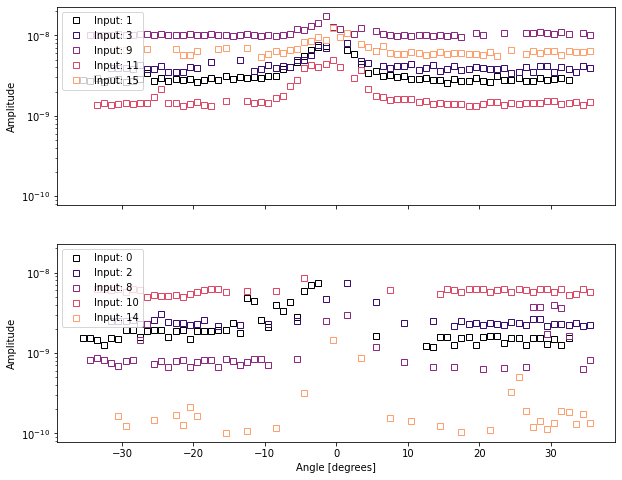

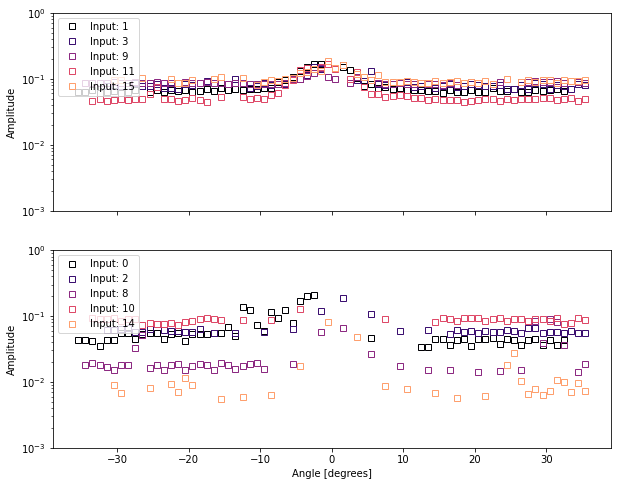

In [19]:
fig,axs = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(10,8)) 
for i,chind in enumerate(N_pols):
    axs[0].semilogy(np.degrees(Ncobeam_bg.d1_centers_grid[col1,:,chind]),Ncobeam_bg.V_LC_operation[col1,:,0,chind],'s',
             color=colorz[i],mfc='none')
    axs[0].semilogy(-1.0*np.degrees(Ncobeam_bg.d1_centers_grid[col2,:,chind]),Ncobeam_bg.V_LC_operation[col2,:,0,chind],'s',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    
for i,chind in enumerate(E_pols):
    axs[1].semilogy(np.degrees(Ecobeam_bg.d1_centers_grid[col1,:,chind]),Ecobeam_bg.V_LC_operation[col1,:,0,chind],'s',
             color=colorz[i],mfc='none')
    axs[1].semilogy(-1.0*np.degrees(Ecobeam_bg.d1_centers_grid[col2,:,chind]),Ecobeam_bg.V_LC_operation[col2,:,0,chind],'s',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    
axs[1].set_xlabel('Angle [degrees]')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
#axs[0].set_ylim(1E-3,1)
plt.show()


fig,axs = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(10,8)) 
for i,chind in enumerate(N_pols):
    axs[0].semilogy(np.degrees(Ncobeam_bg.d1_centers_grid[col1,:,chind]),(1./GNORM_N[chind,find])*Ncobeam_bg.V_LC_operation[col1,:,0,chind],'s',
             color=colorz[i],mfc='none')
    axs[0].semilogy(-1.0*np.degrees(Ncobeam_bg.d1_centers_grid[col2,:,chind]),(1./GNORM_N[chind,find])*Ncobeam_bg.V_LC_operation[col2,:,0,chind],'s',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    
for i,chind in enumerate(E_pols):
    axs[1].semilogy(np.degrees(Ecobeam_bg.d1_centers_grid[col1,:,chind]),(1./GNORM_E[chind,find])*Ecobeam_bg.V_LC_operation[col1,:,0,chind],'s',
             color=colorz[i],mfc='none')
    axs[1].semilogy(-1.0*np.degrees(Ecobeam_bg.d1_centers_grid[col2,:,chind]),(1./GNORM_E[chind,find])*Ecobeam_bg.V_LC_operation[col2,:,0,chind],'s',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    
axs[1].set_xlabel('Angle [degrees]')
axs[0].set_ylabel('Amplitude')
axs[1].set_ylabel('Amplitude')
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')
axs[0].set_ylim(1E-3,1)
plt.show()

<ipython-input-39-2b9c5a7ee705>:13: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ncobeam.V_LC_operation[col2,:,0,chind]),'o',
<ipython-input-39-2b9c5a7ee705>:10: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ncobeam.V_LC_operation[col1,:,0,chind]),'o',
<ipython-input-39-2b9c5a7ee705>:13: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ncobeam.V_LC_operation[col2,:,0,chind]),'o',
<ipython-input-39-2b9c5a7ee705>:10: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ncobeam.V_LC_operation[col1,:,0,chind]),'o',
<ipython-input-39-2b9c5a7ee705>:13: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ncobeam.V_LC_operation[col2,:,0,chind]),'o',
<ipython-input-39-2b9c5a7ee705>:10: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ncobeam.V_LC_operation[col1,:,0,chind]),'o',
<ipython-input-39-2b9c5a7ee705>:24: RuntimeWarning: invalid value encountered in log10
  10*np.log10(Ecobeam.V_LC_operation[

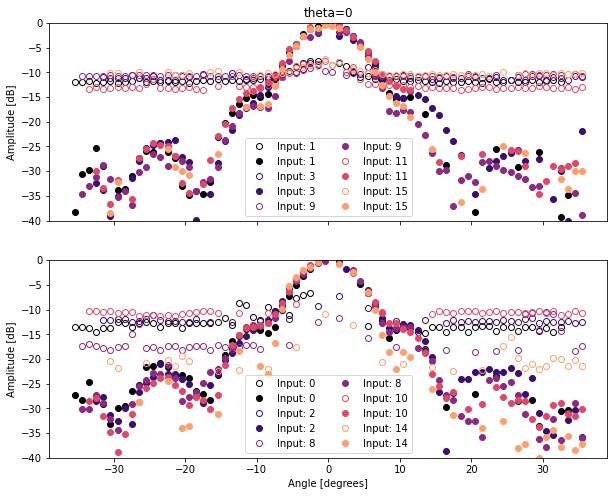

In [39]:
fig,axs = plt.subplots(2, 1, sharex=True,sharey=True,figsize=(10,8)) 
for i,chind in enumerate(N_pols):
    axs[0].plot(np.degrees(Ncobeam_bg.d1_centers_grid[col1,:,chind]),
                    10*np.log10((1./GNORM_N[chind,find])*Ncobeam_bg.V_LC_operation[col1,:,0,chind]),'o',
                 color=colorz[i],mfc='none')
    axs[0].plot(-1.0*np.degrees(Ncobeam_bg.d1_centers_grid[col2,:,chind]),
                    10*np.log10((1./GNORM_N[chind,find])*Ncobeam_bg.V_LC_operation[col2,:,0,chind]),'o',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    axs[0].plot(np.degrees(Ncobeam.d1_centers_grid[col1,:,chind]),
                    10*np.log10(Ncobeam.V_LC_operation[col1,:,0,chind]),'o',
             color=colorz[i])
    axs[0].plot(-1.0*np.degrees(Ncobeam.d1_centers_grid[col2,:,chind]),
                    10*np.log10(Ncobeam.V_LC_operation[col2,:,0,chind]),'o',
             color=colorz[i],label='Input: '+str(chind))
    
for i,chind in enumerate(E_pols):
    axs[1].plot(np.degrees(Ecobeam_bg.d1_centers_grid[col1,:,chind]),
                    10*np.log10((1./GNORM_E[chind,find])*Ecobeam_bg.V_LC_operation[col1,:,0,chind]),'o',
             color=colorz[i],mfc='none')
    axs[1].plot(-1.0*np.degrees(Ecobeam_bg.d1_centers_grid[col2,:,chind]),
                    10*np.log10((1./GNORM_E[chind,find])*Ecobeam_bg.V_LC_operation[col2,:,0,chind]),'o',
             color=colorz[i],mfc='none',label='Input: '+str(chind))
    axs[1].plot(np.degrees(Ecobeam.d1_centers_grid[col1,:,chind]),
                    10*np.log10(Ecobeam.V_LC_operation[col1,:,0,chind]),'o',
             color=colorz[i])
    axs[1].plot(-1.0*np.degrees(Ecobeam.d1_centers_grid[col2,:,chind]),
                    10*np.log10(Ecobeam.V_LC_operation[col2,:,0,chind]),'o',
             color=colorz[i],label='Input: '+str(chind))
    
axs[1].set_xlabel('Angle [degrees]')
axs[0].set_ylabel('Amplitude [dB]')
axs[1].set_ylabel('Amplitude [dB]')
axs[0].legend(loc='lower center',ncol=2)
axs[1].legend(loc='lower center',ncol=2)
axs[0].set_ylim(-40,0)
axs[0].set_title('theta=0')
plt.show()

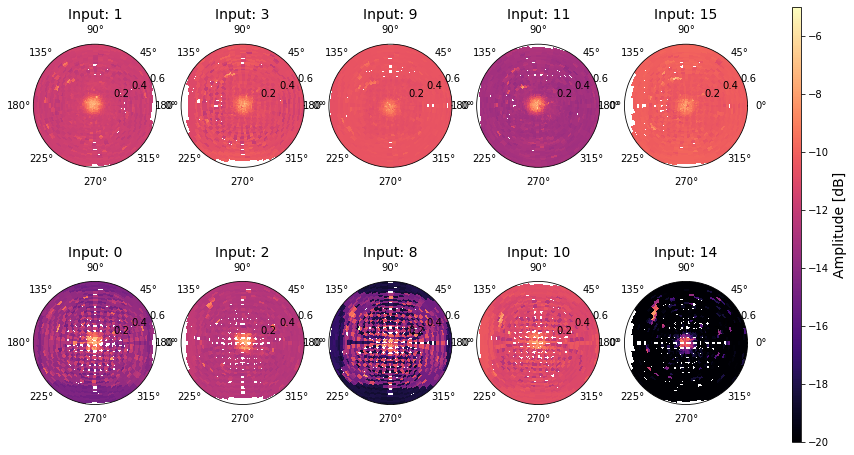

In [33]:
### Polar beam map at freqind 900 ###
fsz=14
ccm = cm.magma

fig, axs = plt.subplots(2, 5, subplot_kw=dict(projection="polar"),figsize=(16,8))

# N pols first
for i,chind in enumerate(N_pols):
    axs[0, i].pcolormesh(Ncobeam_bg.d0_edges_grid[:,:,chind],Ncobeam_bg.d1_edges_grid[:,:,chind],
                10*np.log10((1./GNORM_N[chind,find])*Ncobeam_bg.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-20,vmax=-5)
    axs[0, i].set_title('Input: '+str(chind),fontsize=fsz)

for i,chind in enumerate(E_pols):
    im = axs[1, i].pcolormesh(Ecobeam_bg.d0_edges_grid[:,:,chind],Ecobeam_bg.d1_edges_grid[:,:,chind],
                10*np.log10((1./GNORM_E[chind,find])*Ecobeam_bg.V_LC_operation[:,:,0,chind]),cmap=ccm,vmin=-20,vmax=-5)
    axs[1, i].set_title('Input: '+str(chind),fontsize=fsz)
    #axs[1, i].colorbar()


cbar=fig.colorbar(im,ax=axs,aspect=50)
cbar.set_label('Amplitude [dB]',fontsize=fsz)
plt.show()

In [ ]:
####### CONCAT CHECKS #####
# below, read in concats, plot slices
# then apply normalization, and re-plot

In [ ]:
# Read in concats, optionally apply various normalizations (Gaussian, none)

fly = '618'
pol, pols, cpols, attn, fi = get_flightinfo(fly)
print(fly,pol,pols,cpols, attn)


with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
GNORM = concattest618.G_popt[chind,find,0]
#GNORM = 1.0

fig,axs = plt.subplots(4, 1, sharex=True,figsize=(15,10),squeeze=True)

for fly in Npolflights:

    pol, pols, cpols, attn, fi = get_flightinfo(fly)
    print(fly,pol,pols,cpols, attn)

    with open(glob.glob(pckldir+'*'+fly+'*')[0], 'rb') as pfile:
        print(pfile)
        concattest618=pickle.load(pfile)
    t_cut_618=concattest618.inds_on
    t_cut_618_off = concattest618.inds_off


    ## Let's start by checking regular co-pol normalization - N pol: 

    chind=pols[0]
    print(concattest618.G_popt[chind,find,:])

    x = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,0]
    y = concattest618.drone_xyz_per_dish_interp[chind,t_cut_618,1]
    z = concattest618.V_bg[t_cut_618,find,chind]/GNORM
    z_off = concattest618.V_bg[t_cut_618_off,find,chind]

    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    axs[0].semilogy(y[ixd],z_off[ixd],marker='o',linestyle='None',label=fly)
    ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
    axs[1].semilogy(x[ixd],z_off[ixd],marker='o',linestyle='None',label=fly)
    
    ixd = get_slice_xy(x,y,0.0,ax='x') # grabbed x slice
    axs[2].semilogy(y[ixd],z[ixd],marker='o',linestyle='None',label=fly)
    ixd = get_slice_xy(x,y,0.0,ax='y') # grabbed x slice
    axs[3].semilogy(x[ixd],z[ixd],marker='o',linestyle='None',label=fly)
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel('Y vals')
axs[1].set_xlabel('X vals')
axs[2].legend()
axs[3].legend()
axs[2].set_xlabel('Y vals')
axs[3].set_xlabel('X vals')
axs[0].set_xlim(-40,40)
plt.show()


In [ ]:
# Directly beam map without normalization and check what I get

In [ ]:
with open(glob.glob(pckldir+'FLY618'+'*')[0], 'rb') as pfile:
    print(pfile)
    concattest618=pickle.load(pfile)
GNORM_N = concattest618.G_popt[:,find,0]

In [ ]:
# N pols
concytest=['bgonly/FLY618_20211021T183430Z_ver_20231114T161857_concat_bgonly.pkl',
          'bgonly/FLY619_20211021T185805Z_ver_20231114T164442_concat_bgonly.pkl',
          'bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pk',
          'bgonly/FLY646_20211022T183659Z_ver_20231114T181509_concat_bgonly.pkl',
          'bgonly/FLY647_20211022T185749Z_ver_20231114T183630_concat_bgonly.pkl',
          'bgonly/FLY533_20210826T182904Z_ver_20231114T150159_concat_bgonly.pkl',
          'bgonly/FLY536_20210826T195003Z_ver_20231114T155706_concat_bgonly.pkl']

# beammap a flight, without normalization, and see what hpappens

flights = Npolflights[0:2]
#concytest=[glob.glob(pckldir+'FLY'+fly+'*')[0] for fly in flights]
concytest=['bgonly/FLY618_20211021T183430Z_ver_20231114T161857_concat_bgonly.pkl',
          'bgonly/FLY619_20211021T185805Z_ver_20231114T164442_concat_bgonly.pkl',
          'bgonly/FLY625_20211021T214028Z_ver_20231114T175419_concat_bgonly.pkl',
          'bgonly/FLY646_20211022T183659Z_ver_20231114T181509_concat_bgonly.pkl',
          'bgonly/FLY647_20211022T185749Z_ver_20231114T183630_concat_bgonly.pkl',
          'bgonly/FLY533_20210826T182904Z_ver_20231114T150159_concat_bgonly.pkl',
          'bgonly/FLY536_20210826T195003Z_ver_20231114T155706_concat_bgonly.pkl']
    
delt_the = np.radians(6)
delt_phi = np.radians(1)

chind = N_pols[0]

fig,axs = plt.subplots(2, 1, sharex=True,figsize=(10,8))  
for i in range(0,len(concytest)):
    beam=bp.Beammap(concatlist=[concytest[i]],
                 coordsys='polar',
                 d0args=[-delt_the/2.0,(60*delt_the)-(delt_the/2.0),delt_the],
                 d1args=[0,np.radians(36),delt_phi],
                 normalization='none',operation='coadd',Fargs=[find,find+1,1],vplot=False)
    
    col1,col2 = pu.get_polar_slice(beam.d0_centers_grid[:,:,chind],
                          beam.d1_centers_grid[:,:,chind],0.0)
    axs[0].semilogy(np.degrees(beam.d1_centers_grid[col1,:,chind]),beam.V_LC_operation[col1,:,0,chind],'o',
             label='Flight'+str(i))
    axs[0].semilogy(-1.0*np.degrees(beam.d1_centers_grid[col2,:,chind]),beam.V_LC_operation[col2,:,0,chind],'o',
             label='Flight'+str(i))
    axs[1].semilogy(np.degrees(beam.d1_centers_grid[col1,:,chind]),(1./GNORM_N[chind])*beam.V_LC_operation[col1,:,0,chind],'o',
             label='Flight'+str(i))
    axs[1].semilogy(-1.0*np.degrees(beam.d1_centers_grid[col2,:,chind]),(1./GNORM_N[chind])*beam.V_LC_operation[col2,:,0,chind],'o',
             label='Flight'+str(i))
axs[0].legend()
axs[1].legend()
#axs[0].set_ylim(1E-9,1E-7)
axs[1].set_ylim(5E-2,2E-1)
plt.show()


